## Analyze IMU Errors on 

In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import json

# Get environment variables
import sys
sys.path.append("..")  # Add the parent directory of notebooks to sys.path

from lac.plotting import pose_traces

%load_ext autoreload
%autoreload 2

In [2]:
data_path = "../../outputs/data_collection_1"
json_data = json.load(open(f"{data_path}/data_log.json"))
print(json_data.keys())

dict_keys(['initial_pose', 'lander_pose', 'frames'])


In [10]:
from lac.util import *

G_MOON = 1.62519  # m/s^2

frames = json_data["frames"]
nframes = len(frames)

true_time = np.zeros(nframes)
true_pva = np.zeros((nframes, 9))  # pos, vel, acc
true_att = np.zeros((nframes, 6))  # rpy, rpy_dot
imu_acc = np.zeros((nframes, 3))
imu_gyro = np.zeros((nframes, 3))

rpy_prev = np.zeros(3)

for i, frame in enumerate(frames):
    timestamp = frame["timestamp"]
    pose = np.array(frame["pose"])
    imu_dat = np.array(frame["imu"])

    rpy, pos = pose_to_rpy_pos(pose)
    acc, gyro = imu_dat[:3], imu_dat[3:]

    for j in range(3):
        if rpy[j] - rpy_prev[j] > np.pi:
            rpy[j] -= 2*np.pi
        elif rpy[j] - rpy_prev[j] < -np.pi:
            rpy[j] += 2*np.pi

    rpy_prev = rpy

    # convert acc to inertial frame
    R_b2i = pose[:3, :3]  # using the true pose
    acc = R_b2i @ acc
    
    # remove gravity
    acc[2] -= G_MOON

    true_time[i] = timestamp
    true_pva[i, :3] = pos
    true_att[i, :3] = rpy

    imu_acc[i] = acc
    imu_gyro[i] = gyro

# Get true velocity and acceleration data
true_pva[0, 3:] = np.zeros(6)
true_att[0, 3:] = np.zeros(3)
for i in range(1, nframes):
    dt = true_time[i] - true_time[i-1]
    true_pva[i, 3:6] = (true_pva[i, :3] - true_pva[i-1, :3]) / dt
    diff_att = true_att[i, :3] - true_att[i-1, :3]
    for j in range(3):
        if diff_att[j] > np.pi:
            diff_att[j] -= 2*np.pi
        elif diff_att[j] < -np.pi:
            diff_att[j] += 2*np.pi
    true_att[i, 3:] = diff_att / dt

true_pva[0, 6:] = np.zeros(3)
for i in range(1, nframes-1):
    dt = true_time[i+1] - true_time[i-1]
    true_pva[i, 6:] = (true_pva[i+1, 3:6] - true_pva[i-1, 3:6]) / 2/dt

# Get estimated pose from IMU data
est_posvel = np.zeros((nframes, 6))
est_att = np.zeros((nframes, 6))

est_posvel[0, :6] = true_pva[0, :6]
est_att[0, :6] = true_att[0, :6]

for i in range(1, nframes):
    dt = true_time[i] - true_time[i-1]

    # simple estimate by integrating raw IMU data
    est_posvel[i, :3] = est_posvel[i-1, :3] + est_posvel[i-1, 3:6] * dt
    est_posvel[i, 3:6] = est_posvel[i-1, 3:6] + imu_acc[i] * dt

    # attitude estimate
    est_att[i, :3] = est_att[i-1, :3] + est_att[i-1, 3:] * dt
    est_att[i, 3:6] = imu_gyro[i]


## Plot the IMU Data

Mean acc residuals: [ 0.00035493 -0.00297821 -0.00309587]
Std acc residuals: [0.19564295 0.18823898 0.29209523]
Mean gyro residuals: [-0.00261905  0.00126869 -0.00248592]
Std gyro residuals: [0.118506   0.11133748 0.02316562]


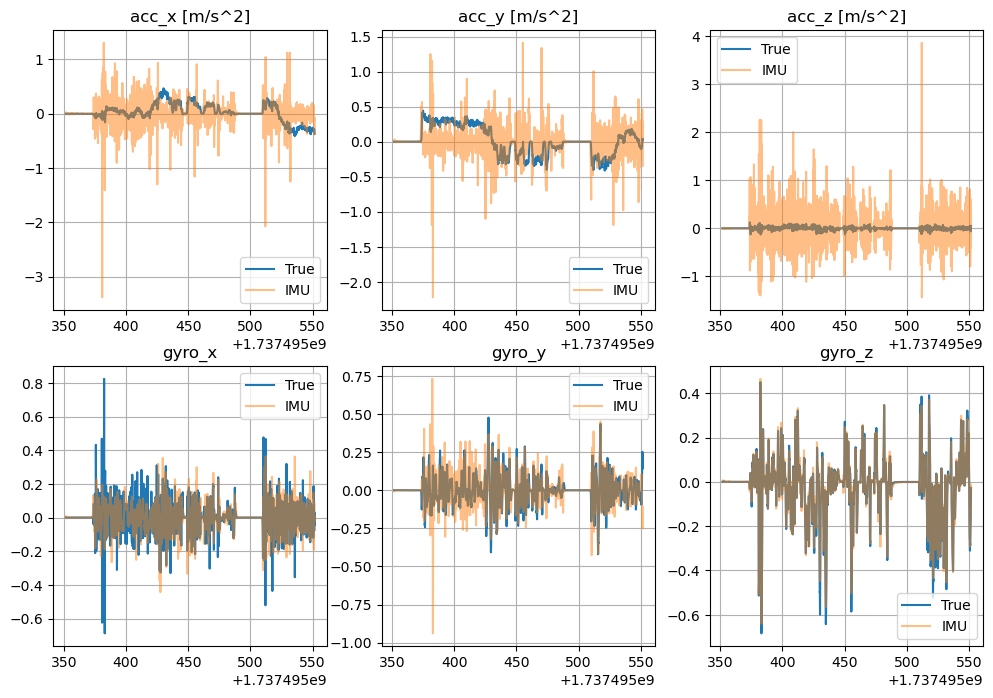

In [8]:
import matplotlib.pyplot as plt

# Get the residuals
res_acc = true_pva[:, 6:] - imu_acc
res_gyro = true_att[:, 3:] - imu_gyro

mean_acc = np.mean(res_acc, axis=0)
std_acc = np.std(res_acc, axis=0)

mean_gyro = np.mean(res_gyro, axis=0)
std_gyro = np.std(res_gyro, axis=0)

print("Mean acc residuals:", mean_acc)
print("Std acc residuals:", std_acc)
print("Mean gyro residuals:", mean_gyro)
print("Std gyro residuals:", std_gyro)


fig, axes = plt.subplots(2, 3, figsize=(12, 8))
pos_labels = ["acc_x [m/s^2]", "acc_y [m/s^2]", "acc_z [m/s^2]", "gyro_x", "gyro_y", "gyro_z"]
for i in range(6):
    ax = axes.flatten()[i]  
    if i < 3:
        ax.plot(true_time, true_pva[:, i+3], label="True")
        ax.plot(true_time, imu_acc[:, i], label="IMU", alpha=0.5)
    else:
        ax.plot(true_time, true_att[:, i], label="True")
        ax.plot(true_time, imu_gyro[:, i-3], label="IMU", alpha=0.5)
    ax.set_title(pos_labels[i])
    ax.legend()
    ax.grid()

plt.show()


## Plot the recorded poses

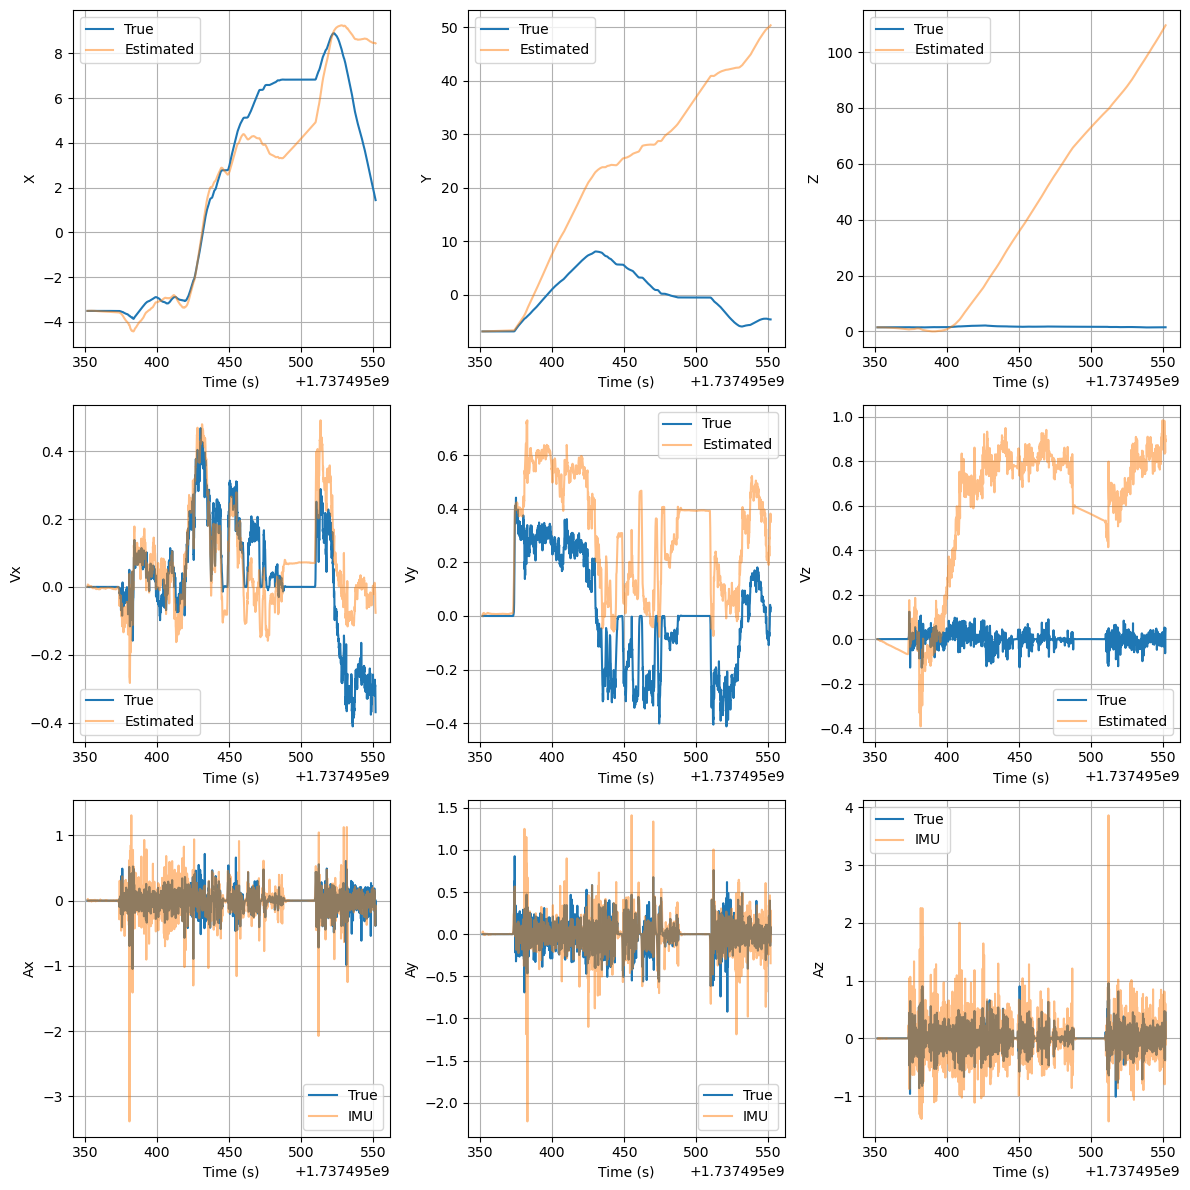

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
pos_labels = ["X", "Y", "Z", "Vx", "Vy", "Vz", "Ax", "Ay", "Az"]
for i in range(9):
    ax = axes.flatten()[i]
    ax.plot(true_time, true_pva[:, i], label="True")
    if i < 6:
        ax.plot(true_time, est_posvel[:, i], label="Estimated", alpha=0.5)
    else:
        ax.plot(true_time, imu_acc[:, i-6], label="IMU", alpha=0.5)
    ax.legend()
    ax.grid()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel(f"{pos_labels[i]}")

plt.tight_layout()
plt.show()


## Plot Recorded Attitude

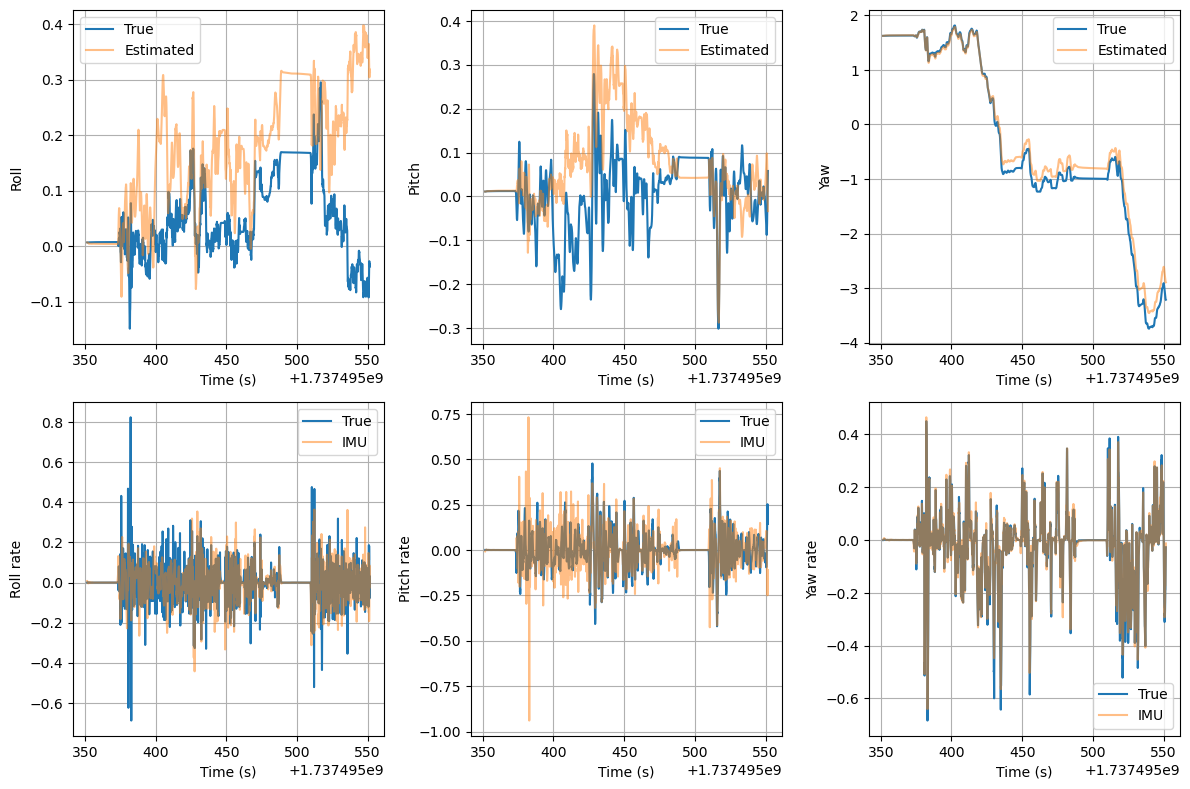

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
pos_labels = ["Roll", "Pitch", "Yaw", "Roll rate", "Pitch rate", "Yaw rate"]
for i in range(6):
    ax = axes.flatten()[i]
    ax.plot(true_time, true_att[:, i], label="True")
    if i < 3:
        ax.plot(true_time, est_att[:, i], label="Estimated", alpha=0.5)
    else:
        ax.plot(true_time, imu_gyro[:, i-3], label="IMU", alpha=0.5)
    ax.legend()
    ax.grid()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel(f"{pos_labels[i]}")

plt.tight_layout()
plt.show()